In [20]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [21]:
%cd gdrive/MyDrive/atlantic-hurricane-trajectory-prediction/docs

[Errno 2] No such file or directory: 'gdrive/MyDrive/atlantic-hurricane-trajectory-prediction/docs'
/content/gdrive/MyDrive/atlantic-hurricane-trajectory-prediction/docs


In [22]:
!ls

data  errors


In [23]:
%autosave 60

Autosaving every 60 seconds


In [24]:
# Import various libraries throughout the software
from pprint import pprint
from datetime import timedelta
from sklearn.preprocessing import RobustScaler
from geopy.distance import great_circle as vc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math as Math
import datetime
import dateutil
import io

In [25]:
# data cleaning/processing: (from hurricane-net, hammad)
db = []
with open('data/hurdat2-1851-2022-050423.txt') as raw: 
    for line in raw: 
        line = line.replace(' ', '').split(',')
    
        # Identify atlantic storm, first 2 letters should be AL
        if (line[0][:2] == 'AL') :
            storm_id = line[0]
            storm_name = line[1]
            storm_entries = line[2]

            # Iterate and read through best track entries
            for i in range(int(storm_entries)) :
                entry = raw.readline().replace(' ', '').split(',')
                # Filter -999 placeholder for missing central pressure
                entry = [None if x == "-999" else x for x in entry]
                # Construct date and time based on first two columns
                timestamp = datetime.datetime(int(entry[0][:4]), int(entry[0][4:6]), int(entry[0][6:8]), int(entry[1][:2]), int(entry[1][3:]))
                # Add entry into our current database
                db.append([storm_id, storm_name, timestamp] + entry[2:-1])
        else :
            print("Error, unidentified storm ".join(str(line[0])))

# Return DataFrame
dataset = pd.DataFrame(db, columns = ['storm_id', 'storm_name', 'entry_time', 'entry_id', 'entry_status', 'lat', 'long','max_wind', 'min_pressure', '34kt_ne', '34kt_se', '34kt_sw', '34kt_nw', '50kt_ne', '50kt_se', '50kt_sw', '50kt_nw', '64kt_ne', '64kt_se', '64kt_sw', '64kt_nw'])

In [26]:
models = dict()
class model :
  '''
  PURPOSE: To create a class for each model included in the forecast error database
  METHOD: Provide an API
  OUTOUT: A class with a DataFrame and associated operations
  '''
  name = None
  # Dictionary key: STMID
  storm = dict()
  def __init__(self, model_name) :
    self.name = model_name
    return

with open('errors/1970-present_OFCL_v_BCD5_ind_ATL_TI_errors_noTDs.txt') as raw :
    lines = raw.readlines()
    
    # Get model names and declare model objects
    line = lines[1].split()
    model_names = line[2:]
    for model_name in model_names :
        models[model_name] = model(model_name)
    
    # Data starts at line 9 
    for line in lines[9:] :
        line = line.split()
        # Identify atlantic storm date, storm id, associated sample sizes, latitude and longitude, and windspeed
        timestamp = datetime.datetime.strptime(line[0], "%d-%m-%Y/%H:%M:%S")
        storm_id = line[1]
        sample_sizes = {"F012": float(line[2]), "F024": float(line[3]),"F036": float(line[4]), "F048": float(line[5]), "F072": float(line[6]), "F096": float(line[7]), "F120": float(line[8]), "F144": float(line[9]), "F168": float(line[10])} 
        latitude = float(line[11])
        longitude = float(line[12])
        wind_speed = float(line[13])
    
                
        # Iterate through model forecast track and intensity errors 
        for i in range(len(model_names)) :
            intensity_forecast = dict(list(zip([timestamp, timestamp + timedelta(hours = 12), timestamp + timedelta(hours = 24), timestamp + timedelta(hours = 36), timestamp + timedelta(hours = 48), timestamp + timedelta(hours = 72), timestamp + timedelta(hours = 96), timestamp + timedelta(hours = 120), timestamp + timedelta(hours = 144), timestamp + timedelta(hours = 168)], [None if x == "-9999.0" else float(x) for x in line[14 + (20 * i) : 24 + (20 * i)]])))
            track_forecast = dict(list(zip([timestamp, timestamp + timedelta(hours = 12), timestamp + timedelta(hours = 24), timestamp + timedelta(hours = 36), timestamp + timedelta(hours = 48), timestamp + timedelta(hours = 72), timestamp + timedelta(hours = 96), timestamp + timedelta(hours = 120), timestamp + timedelta(hours = 144), timestamp + timedelta(hours = 168)], [None if x == "-9999.0" else float(x) for x in line[24 + (20 * i) : 34 + (20 * i)]])))
        
        # Add forecast to model and storm, initialize if storm id does not exist
        if storm_id not in models[model_names[i]].storm.keys() :
            models[model_names[i]].storm[storm_id] = dict()

        models[model_names[i]].storm[storm_id].update({
            timestamp : {
            "sample_sizes" : sample_sizes,
            "lat" : latitude,
            "long" : longitude,
            "wind_speed" : wind_speed,
            "intensity_forecast" : intensity_forecast,
            "track_forecast" : track_forecast,
            }
        })

In [27]:
# Show the first 3 OFCL hurricane model errors for Hurricane Katrina 2005 on 28-08-2005/18:00:00
pprint(models['OFCL'].storm['AL122005'][datetime.datetime(2005, 8, 28, 18, 0)], indent = 8)

{       'intensity_forecast': {       datetime.datetime(2005, 8, 28, 18, 0): None,
                                      datetime.datetime(2005, 8, 29, 6, 0): None,
                                      datetime.datetime(2005, 8, 29, 18, 0): None,
                                      datetime.datetime(2005, 8, 30, 6, 0): 0.0,
                                      datetime.datetime(2005, 8, 30, 18, 0): 20.9,
                                      datetime.datetime(2005, 8, 31, 18, 0): 93.6,
                                      datetime.datetime(2005, 9, 1, 18, 0): 170.2,
                                      datetime.datetime(2005, 9, 2, 18, 0): None,
                                      datetime.datetime(2005, 9, 3, 18, 0): None,
                                      datetime.datetime(2005, 9, 4, 18, 0): None},
        'lat': 0.0,
        'long': 26.3,
        'sample_sizes': {       'F012': 0.33,
                                'F024': 0.33,
                                'F036': 0

In [28]:
# Show the first 5 records from Hurricane Katrina 2005 (AL122005)
dataset.query('storm_id == "AL122005"').head()

,storm_id,storm_name,entry_time,entry_id,entry_status,lat,long,max_wind,min_pressure,34kt_ne,...,34kt_sw,34kt_nw,50kt_ne,50kt_se,50kt_sw,50kt_nw,64kt_ne,64kt_se,64kt_sw,64kt_nw
44681,AL122005,KATRINA,2005-08-23 18:00:00,,TD,23.1N,75.1W,30,1008,0,...,0,0,0,0,0,0,0,0,0,0
44682,AL122005,KATRINA,2005-08-24 00:00:00,,TD,23.4N,75.7W,30,1007,0,...,0,0,0,0,0,0,0,0,0,0
44683,AL122005,KATRINA,2005-08-24 06:00:00,,TD,23.8N,76.2W,30,1007,0,...,0,0,0,0,0,0,0,0,0,0
44684,AL122005,KATRINA,2005-08-24 12:00:00,,TS,24.5N,76.5W,35,1006,60,...,0,0,0,0,0,0,0,0,0,0
44685,AL122005,KATRINA,2005-08-24 18:00:00,,TS,25.4N,76.9W,40,1003,60,...,0,0,0,0,0,0,0,0,0,0


# Transform Data
The following code will tranform the hurricane best path data into objects that can be better manipulated for processing. to match between datasets, we will also create a storm_id dictionary to store storm names matched with ID's

In [29]:
# Create hurricane class
class hurricane(object) : 
    def __init__(self, name, id) :
        # Set instance variables
        self.name = name
        self.id = id
        self.entries = dict()
        self.models = dict()
        
        return
    # Add hurricane track entry based on standard HURDAT2 format
    def add_entry(self, array) :
        entry = {
            array[0] : { # dateteime of entry
                'entry_time' : array[0], 
                'entry_id' : array[1],
                'entry_status' : array[2],
                'lat' : float(array[3][:-1]), # Convert to number from format '#.#N'
                'long' : float(array[4][:-1]), # Convert to number from format '#.#W'
                'max_wind' : float(array[5]),
                'min_pressure' : 980 if array[6] is None else float(array[6]), # Early records are -999 or None
                'wind_radii' :  array[7:], # Array based on HURDAT2 format
                'distance': 0,
                'direction': 0
            }
        }
        self.entries.update(entry)
        
        return
    # Add hurricane model errors
    def add_model(self, name, model) :
        self.models[name] = model
        
        return


    def update_dist_direc(self):
      t = pd.DataFrame(self.entries.values())
      dst = 0
      prev = (0,0)
      
      # For all latitude and longitude points of hurricane, calculate the angle of travel and distance
      for index,p in enumerate(zip(t['lat'], t['long'])):
          
          if prev == (0,0):
              prev = p
              continue 
          # Stores the distance into the DataFrame
          list(self.entries.values())[index]['distance'] = vc(prev,p).miles
          
          dLon = p[1] - prev[1];  
          temp = float(p[0]) # p[0] is a str?
          y_x = Math.sin(dLon) * Math.cos(temp);
          
          x_x = Math.cos(p[1]) * Math.sin(temp) - Math.sin(p[1]) * Math.cos(temp) * Math.cos(dLon);
          brng = Math.degrees(Math.atan2(y_x, x_x)) 
          if (brng < 0):
              brng+= 360;
          
          # Stores the angle of travel into the DataFrame
          list(self.entries.values())[index]['direction'] = brng
          # if self.id == 'AL122005' and index==2:
          if self.id == 'AL081994' and index==2:
            print(f'p[1]:{p[1]}')
            print(f'prev[1]:{prev[1]}')
            print(f'dLon:{dLon}')
            print(f'temp:{temp}')
            print(f'y_x:{y_x}')
            print(f'x_x:{x_x}')
            print(f'brng:{brng}')
          dst += vc(prev,p).miles
          prev = p

# Storm ID Key for matching between datasets
storm_ids = dict()
# Parse in hurricanes
hurricanes = dict()

print("Transforming HURDAT2 into objects . . .")
for index, entry in dataset.iterrows() :
    print("Transforming {}/{} entries from HURDAT2".format(index + 1, len(dataset)), end = "\r")
    # New hurricane
    if entry['storm_id'] not in hurricanes :
        hurricanes[entry['storm_id']] = hurricane(entry['storm_name'], entry['storm_id'])
        storm_ids[entry['storm_id']] = entry['storm_name']
    # Add entry to hurricane
    hurricanes[entry['storm_id']].add_entry(entry[2:])
print("\nDone!")

Transforming HURDAT2 into objects . . .
Transforming 53976/53976 entries from HURDAT2
Done!


# Load Data
The following will finalize our preliminary data preparation by loading some of the errors into each hurricane object. Note that models start from the year 1970 and any hurricane before that has no previous model data.

In [30]:
# Get all available model errors
# Load model errors into hurricanes
for id in storm_ids :
    for model in models :
        # Skip if this hurricane does not have the model
        if id not in models[model].storm :
            continue
        hurricanes[id].add_model(model, models[model].storm[id])
    hurricanes[id].update_dist_direc()

p[1]:85.9
prev[1]:85.1
dLon:0.8000000000000114
temp:16.5
y_x:-0.5038688074294795
x_x:-0.09353734284162374
brng:259.4834249123352


In [31]:
#will test distance and direction of the bulk update vs individual update
t=pd.DataFrame(hurricanes['AL081994'].entries.values())
t

,entry_time,entry_id,entry_status,lat,long,max_wind,min_pressure,wind_radii,distance,direction
0,1994-09-24 12:00:00,,TD,16.0,84.5,25.0,1008.0,34kt_ne None 34kt_se None 34kt_sw Non...,0.000000,0.000000
1,1994-09-24 18:00:00,,TD,16.3,85.1,30.0,1007.0,34kt_ne None 34kt_se None 34kt_sw Non...,44.891903,306.719439
2,1994-09-25 00:00:00,,TD,16.5,85.9,30.0,1007.0,34kt_ne None 34kt_se None 34kt_sw Non...,54.796781,259.483425
3,1994-09-25 06:00:00,,TD,16.6,86.7,30.0,1006.0,34kt_ne None 34kt_se None 34kt_sw Non...,53.433344,214.647871
4,1994-09-25 12:00:00,,TD,16.7,87.6,30.0,1005.0,34kt_ne None 34kt_se None 34kt_sw Non...,59.976134,205.375417
5,1994-09-25 18:00:00,L,TD,16.6,88.4,30.0,1004.0,34kt_ne None 34kt_se None 34kt_sw Non...,53.406014,220.828574
6,1994-09-26 00:00:00,,TD,16.6,88.7,30.0,1006.0,34kt_ne None 34kt_se None 34kt_sw Non...,19.864134,226.705956
7,1994-09-26 06:00:00,,TD,16.6,88.9,25.0,1007.0,34kt_ne None 34kt_se None 34kt_sw Non...,13.242757,284.940686
8,1994-09-26 12:00:00,,TD,16.5,89.2,25.0,1007.0,34kt_ne None 34kt_se None 34kt_sw Non...,21.036343,332.536353
9,1994-09-26 18:00:00,,TD,16.5,89.5,25.0,1007.0,34kt_ne None 34kt_se None 34kt_sw Non...,19.874439,342.171773


In [32]:
t['dist']=0
t['direc']=0

In [33]:
#testing for one hurricane
prev=(0,0)
for index,p in enumerate(zip(t['lat'], t['long'])):
  if prev == (0,0):
    prev = p
    print(f'index:{index},prev:{prev}')
    continue 
  # Stores the distance into the DataFrame
  t.at[index,'dist'] = vc(prev,p).miles

  dLon = p[1] - prev[1];  
  temp = float(p[0]) # p[0] is a str?
  y_x = Math.sin(dLon) * Math.cos(temp);

  x_x = Math.cos(p[1]) * Math.sin(temp) - Math.sin(p[1]) * Math.cos(temp) * Math.cos(dLon);
  brng = Math.degrees(Math.atan2(y_x, x_x)) 
  if (brng < 0):
    brng+= 360;
  t.at[index,'direc'] = brng
  if index==2:
    print(f'p[1]:{p[1]}')
    print(f'prev[1]:{prev[1]}')
    print(f'dLon:{dLon}')
    print(f'temp:{temp}')
    print(f'y_x:{y_x}')
    print(f'x_x:{x_x}')
    print(f'brng:{brng}')
  print(index,t.at[index,'direc'])
  prev = p

index:0,prev:(16.0, 84.5)
1 306.71943856277255
p[1]:85.9
prev[1]:85.1
dLon:0.8000000000000114
temp:16.5
y_x:-0.5038688074294795
x_x:-0.09353734284162374
brng:259.4834249123352
2 259.4834249123352
3 214.6478709156233
4 205.37541693715318
5 220.82857383503298
6 226.7059563604921
7 284.9406861076747
8 332.53635339353264
9 342.17177270335054


In [34]:
t #to check that distance calculation and direction calculation from bulk vs individual

,entry_time,entry_id,entry_status,lat,long,max_wind,min_pressure,wind_radii,distance,direction,dist,direc
0,1994-09-24 12:00:00,,TD,16.0,84.5,25.0,1008.0,34kt_ne None 34kt_se None 34kt_sw Non...,0.000000,0.000000,0.000000,0.000000
1,1994-09-24 18:00:00,,TD,16.3,85.1,30.0,1007.0,34kt_ne None 34kt_se None 34kt_sw Non...,44.891903,306.719439,44.891903,306.719439
2,1994-09-25 00:00:00,,TD,16.5,85.9,30.0,1007.0,34kt_ne None 34kt_se None 34kt_sw Non...,54.796781,259.483425,54.796781,259.483425
3,1994-09-25 06:00:00,,TD,16.6,86.7,30.0,1006.0,34kt_ne None 34kt_se None 34kt_sw Non...,53.433344,214.647871,53.433344,214.647871
4,1994-09-25 12:00:00,,TD,16.7,87.6,30.0,1005.0,34kt_ne None 34kt_se None 34kt_sw Non...,59.976134,205.375417,59.976134,205.375417
5,1994-09-25 18:00:00,L,TD,16.6,88.4,30.0,1004.0,34kt_ne None 34kt_se None 34kt_sw Non...,53.406014,220.828574,53.406014,220.828574
6,1994-09-26 00:00:00,,TD,16.6,88.7,30.0,1006.0,34kt_ne None 34kt_se None 34kt_sw Non...,19.864134,226.705956,19.864134,226.705956
7,1994-09-26 06:00:00,,TD,16.6,88.9,25.0,1007.0,34kt_ne None 34kt_se None 34kt_sw Non...,13.242757,284.940686,13.242757,284.940686
8,1994-09-26 12:00:00,,TD,16.5,89.2,25.0,1007.0,34kt_ne None 34kt_se None 34kt_sw Non...,21.036343,332.536353,21.036343,332.536353
9,1994-09-26 18:00:00,,TD,16.5,89.5,25.0,1007.0,34kt_ne None 34kt_se None 34kt_sw Non...,19.874439,342.171773,19.874439,342.171773


In [35]:
models.keys()

dict_keys(['OFCL', 'BCD5'])

# Feature Engineering & Data Augmentation
The following section will extract the relevant features and engineer each data point so that we can fit it into the model. Because the type of inputs are important, the features will be transformed based on the model architecture. This will also include data augmentation methods. The higher level architecture will be a deep learning recurrent neural network with LSTM and time distributed layers.

In [36]:
def feature_extraction(timestep, previous) :
    '''
    PURPOSE: Calculate the features for a machine learning model within the context of hurricane-net
    METHOD: Use the predictors and the calculation methodology defined in Knaff 2013
    INPUT:  timestep - current dictionary of features in the hurricane object format
            previous - previous timestep dictionary of features in the hurricane object format
    OUTPUT: Dictionary of features
    
    timestep = {
      'lat' : float,
      'long' : float,
      'max-wind' : float,
      'entry-time' : datetime
    }
    '''
    features = {
        'lat' : timestep['lat'],
        'long' : timestep['long'],
        'max_wind' : timestep['max_wind'],
        'delta_wind' : (timestep['max_wind'] - previous['max_wind']) / # Calculated from track (12h)
            ((timestep['entry_time'] - previous['entry_time']).total_seconds() / 43200),
        'min_pressure' : timestep['min_pressure'], 
        'zonal_speed' : (timestep['lat'] - previous['lat'])/ # Calculated from track (per hour)
            ((timestep['entry_time'] - previous['entry_time']).total_seconds() / 3600),
        'meridonal_speed' : (timestep['long'] - previous['long'])/# Calculated from track (per hour)
            ((timestep['entry_time'] - previous['entry_time']).total_seconds() / 3600),
        'year' : timestep['entry_time'].year,
        'month' : timestep['entry_time'].month,
        'day' : timestep['entry_time'].day,
        'hour' : timestep['entry_time'].hour,
        'delta_pressure': (timestep['min_pressure'] - previous['min_pressure']) /
            ((timestep['entry_time'] - previous['entry_time']).total_seconds() / 43200),
        'distance': timestep['distance'],
        'direction': timestep['direction']
    }
    return features
    
def storm_x_y(storm, timesteps = 1, lag = 24) :
    '''
    PURPOSE: Create independent and dependent samples for a machine learning model based on the timesteps
    METHOD: Use the HURDAT2 database and a hurricane object as defined in hurricane-net for feature extraction
    INPUT:  storm - hurricane object
            timesteps - (default = 1) number of timesteps to calculate
            include_none - (default = False) Boolean for including None in test data. Imputing function unavailable.
            lag - (default = 24) lag in hours for the dependent variables up to 5 days
    OUTPUT: Dictionary with independent (x) and dependent (y) values.
    '''
    x = []
    # Create testing data structure with a dictionary
    times = [time * lag for time in range(1, (120 // lag) + 1)] # Begin at lag hours with lag increments up to 120h inclusive
    y = dict([(time,[]) for time in times])
    
    # Sort by entry time
    entries = [entry[1] for entry in sorted(storm.entries.items())]
    
    for index in range(len(entries)) :
        if index < timesteps : # Flag for insufficient initial time steps
            continue

        # If we're not including None values, check to see if there will be any
        if None in [storm.entries.get(entries[index]['entry_time'] +
                                         datetime.timedelta(hours = future)) for future in times] : break
            
        # Calculate time steps and their features for independent values
        sample = []
        for step in range(timesteps) :
            # Training sample
            timestep = entries[index - step]
            previous = entries[index - step - 1]
            sample.append([timestep['entry_time']] + [[feature_extraction(timestep, previous)]])
        x.append(sample) # Add our constructed sample
        
        # Calculate time steps and their features for dependent values
        for future in times :
            timestep = storm.entries.get(entries[index]['entry_time'] + datetime.timedelta(hours = future))
            previous = storm.entries.get(entries[index]['entry_time'] + datetime.timedelta(hours = future - lag))
            
            if timestep and previous: 
                y[future].append(feature_extraction(timestep, previous))
            else :
                y[future].append(None)
    
    # Return output, if there is no output, return None.
    if len(x) == 0 :
        return None
    else:
        return {'x': x, 'y': y}
def shape(hurricanes, timesteps, remove_missing = True) :
    '''
    PURPOSE: Shape our data for input into machine learning models
    METHOD: Use a numpy array to shape into (samples, timesteps, features)
    INPUT:  hurricanes - dictionary of hurricane objects
            timesteps - number of timesteps for the shape
            remove_missing - boolean indicating whether the algorithm will disregard missing values
    OUTPUT: numpy array of shape (samples, timesteps, 11) where 11 is the number of predictors in a hurricane object
    '''
    x = []
    y = []
    lag = 24 # lag time in hours
    precision = np.float64 # defines the precision of our data type
    times = [time * lag for time in range(1, (120 // lag) + 1)] # Begin at lag hours with lag increments up to 120h inclusive
    count = 0
    for hurricane in hurricanes.values() :
        count += 1
        result = storm_x_y(hurricane, timesteps, lag)
        if result is None :
            continue
        # Extract only the values from the strom features using our specified precision
        hurricane_x = np.array(
            [[list(sample[1][0].values()) for sample in x] for x in result['x']],
            dtype = precision)
        hurricane_y = np.array(
            [[list(result['y'][time][index].values()) for time in times] for index in range(len(result['y'][lag]))],
            dtype = precision)
        # Disregard if algorithm requires no missing values
        if remove_missing :
            if (len(np.where(np.isnan(hurricane_x))[0]) > 0) or (len(np.where(np.isnan(hurricane_y))[0]) > 0) :
                continue
        # Add to our results
        x.extend(hurricane_x)
        y.extend(hurricane_y)
        print("Feature engineered {}/{} hurricanes for {} timestep(s)".format(count, len(hurricanes), timesteps), end = "\r")
    print("\nDone feature engineering hurricanes.")
    
    return {'x': np.array(x), 'y': np.array(y)}
def scaler(processed_data, hurricanes) :
    '''
    PURPOSE: Scale our data using the RobustScaler method from the sklearn library
    METHOD: Generate data using 1 timesteps and then remove the NaN or None types to use the scaler methods
    INPUT:  hurricanes - dictionary of hurricane objects
            processed_data - dictionary of x and y values of data produced by shape() function with no missing values
    OUTPUT: 1) Scaled processed_data using RobustScaler
            2) RobustScaler object fit with appropriate data
    '''
    print("Scaling Data . . . (1 timestep for unqiue data)")
    # Create our scaler
    unqiue_data = shape(hurricanes, timesteps = 1)
    x = np.reshape(unqiue_data['x'], (unqiue_data['x'].shape[0], -1))
    x = np.delete(x, np.where(np.isnan(x))[0], 0)
    scaler = RobustScaler()
    scaler.fit(x)
    
    # Scale our data
    for index in range(len(processed_data['x'])) :
        # Scale our x
        processed_data['x'][index] = scaler.transform(processed_data['x'][index])
        # Scale our y
        processed_data['y'][index] = scaler.transform(processed_data['y'][index])
    print("Done scaling.")
    return processed_data, scaler
# Finalize and scale procesed data into a dictionary
preprocessed_data = shape(hurricanes, timesteps = 5)
processed_data, scaler = scaler(preprocessed_data, hurricanes)

Feature engineered 1944/1952 hurricanes for 5 timestep(s)
Done feature engineering hurricanes.
Scaling Data . . . (1 timestep for unqiue data)
Feature engineered 1952/1952 hurricanes for 1 timestep(s)
Done feature engineering hurricanes.
Done scaling.


# Model Architecture

In [37]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)

from tensorflow.keras.layers import LSTM, Dense, Input, Lambda, Attention, Layer, TimeDistributed
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import numpy as np

class AttentionLayer(Layer):
    def __init__(self, hidden_size):
        super(AttentionLayer, self).__init__()
        self.hidden_size = hidden_size

    def build(self, input_shape):
        self.context_vector = self.add_weight(shape=(self.hidden_size,),
                                              initializer='random_normal',
                                              trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        hidden_states, _ = inputs

        context_vector = tf.expand_dims(self.context_vector, axis=0)
        context_vector = tf.repeat(context_vector, tf.shape(hidden_states)[0], axis=0)

        attention_weights = tf.einsum('ijk,ik->ij', hidden_states, context_vector)
        attention_weights = tf.keras.layers.Activation('softmax')(attention_weights)

        weighted_sum = tf.einsum('ij,ijk->ik', attention_weights, hidden_states)

        return weighted_sum

In [38]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np
from keras.layers import TimeDistributed, Reshape, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, Activation, Dropout, TimeDistributed, dot

def attention_layer(inputs):
    hidden_states, context_vector = inputs
    
    hidden_size = int(hidden_states.shape[2])
    
    # Reshape context vector to perform element-wise multiplication
    context_vector = Dense(hidden_size)(context_vector)
    context_vector = tf.repeat(context_vector, tf.shape(hidden_states)[1], axis=1)
    
    # Attention mechanism
    attention_weights = tf.keras.layers.Attention()([hidden_states, context_vector])
    attention_weights = tf.keras.layers.Activation('softmax')(attention_weights)
    
    # Weighted sum of hidden states
    weighted_sum = tf.reduce_sum(attention_weights * hidden_states, axis=1)
    
    return weighted_sum

def build_model(input_shape, hidden_units, output_dim, dropout_rate=0.15, recurrent_dropout_rate=0.15):
    inputs = Input(shape=input_shape)
    lstm_output = LSTM(hidden_units, return_sequences=True, dropout=dropout_rate, recurrent_dropout=recurrent_dropout_rate)(inputs)
    attention_output = AttentionLayer(hidden_units)([lstm_output, lstm_output])
    
    # Add a time step dimension
    reshaped_output = Reshape((-1, hidden_units))(attention_output)
    
    time_distributed_output = TimeDistributed(Dense(output_dim))(reshaped_output)

    model = Model(inputs=inputs, outputs=time_distributed_output)
    return model

def train_model(X_train, X_test, y_train, y_test, output_dim, n_epochs):
    input_shape = X_train.shape[1:]
    hidden_units = 128

    model = build_model(input_shape, hidden_units, output_dim)
    model.summary()

    model.compile(optimizer='adam', loss='mean_squared_error')

    loss = []
    val_loss = []
    for epoch in range(n_epochs):
        # Early stopping
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        print(f"Epoch {epoch+1}/{n_epochs}")
        history = model.fit(X_train, y_train, epochs=1, batch_size=512, validation_data=(X_test, y_test), verbose=1)
        print("Loss:", history.history['loss'][0])
        loss.append(history.history['loss'][0])
        print("Validation Loss:", history.history['val_loss'][0])
        val_loss.append(history.history['val_loss'][0])
        print()

    return model, history, loss, val_loss

# Create our cross-validation data structure
# In the first step we will split the data in training and remaining dataset
X_train, X_rem, y_train, y_rem = train_test_split(processed_data['x'], processed_data['y'], train_size=0.8)
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5)

# Define the features to train for
features = [2, 0, 1]  # Specify the indices of the features to train for

# Train multiple models
models = []
histories = []
losses = []
val_losses = []
n_epochs = 750

for feature_idx in features:
    y_train_feature = np.array([[[features[feature_idx]] for features in y] for y in y_train], dtype=np.float64)
    y_valid_feature = np.array([[[features[feature_idx]] for features in y] for y in y_valid], dtype=np.float64)
    
    model, history, loss, val_loss = train_model(X_train, X_valid, y_train_feature, y_valid_feature, output_dim=1, n_epochs=n_epochs)
    
    models.append(model)
    histories.append(history)
    losses.append(loss)
    val_losses.append(val_loss)

# Access the history of each model
for i, history in enumerate(histories):
    print(f"History for Model {i+1}")
    print("Loss:", history.history['loss'])
    print("Validation Loss:", history.history['val_loss'])
    print()


Exception ignored in: <function _xla_gc_callback at 0x7f1bd32c4e50>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 103, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 5, 14)]      0           []                               
                                                                                                  
 lstm_1 (LSTM)                  (None, 5, 128)       73216       ['input_2[0][0]']                
                                                                                                  
 attention_layer_1 (AttentionLa  (None, 128)         128         ['lstm_1[0][0]',                 
 yer)                                                             'lstm_1[0][0]']                 
                                                                                                  
 reshape_1 (Reshape)            (None, 1, 128)       0           ['attention_layer_1[0][0]']

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


21/21 [==============================] - 3s 122ms/step - loss: 0.4114 - val_loss: 0.3337
Loss: 0.4113815426826477
Validation Loss: 0.3337048888206482

Epoch 2/750
21/21 [==============================] - 2s 119ms/step - loss: 0.3292 - val_loss: 0.3235
Loss: 0.32916679978370667
Validation Loss: 0.3234860599040985

Epoch 3/750
21/21 [==============================] - 3s 121ms/step - loss: 0.3166 - val_loss: 0.3159
Loss: 0.3165518343448639
Validation Loss: 0.3158635199069977

Epoch 4/750
20/21 [===========================>..] - ETA: 0s - loss: 0.3111

KeyboardInterrupt: ignored

In [ ]:
# save model 
wind_model = models[0]
lat_model = models[1]
long_model = models[2]

wind_loss = np.array(losses[0])
lat_loss = np.array(losses[1])
long_loss = np.array(losses[2])

wind_val_loss = np.array(val_losses[0])
lat_val_loss = np.array(val_losses[1])
long_val_loss = np.array(val_losses[2])

folder_path_loss = '/content/gdrive/MyDrive/atlantic-hurricane-trajectory-prediction/outputs/lstm_attention/losses'
folder_path_val_loss = '/content/gdrive/MyDrive/atlantic-hurricane-trajectory-prediction/outputs/lstm_attention/val_losses'

np.save(f'{folder_path_loss}/wind_loss.npy', wind_loss)
np.save(f'{folder_path_loss}/lat_loss.npy', lat_loss)
np.save(f'{folder_path_loss}/long_loss.npy', long_loss)

np.save(f'{folder_path_val_loss}/wind_loss.npy', wind_val_loss)
np.save(f'{folder_path_val_loss}/lat_loss.npy', lat_val_loss)
np.save(f'{folder_path_val_loss}/long_loss.npy', long_val_loss)

wind_model.save('/content/gdrive/MyDrive/atlantic-hurricane-trajectory-prediction/outputs/lstm_attention/trained_models/wind_model.h5')
lat_model.save('/content/gdrive/MyDrive/atlantic-hurricane-trajectory-prediction/outputs/lstm_attention/trained_models/lat_model.h5')
long_model.save('/content/gdrive/MyDrive/atlantic-hurricane-trajectory-prediction/outputs/lstm_attention/trained_models/long_model.h5')

In [39]:
from tensorflow import keras

# Predict values
wind_model = keras.models.load_model('/content/gdrive/MyDrive/atlantic-hurricane-trajectory-prediction/outputs/lstm_attention/trained_models/wind_model.h5', custom_objects={'AttentionLayer': AttentionLayer})
lat_model = keras.models.load_model('/content/gdrive/MyDrive/atlantic-hurricane-trajectory-prediction/outputs/lstm_attention/trained_models/lat_model.h5', custom_objects={'AttentionLayer': AttentionLayer})
long_model = keras.models.load_model('/content/gdrive/MyDrive/atlantic-hurricane-trajectory-prediction/outputs/lstm_attention/trained_models/long_model.h5', custom_objects={'AttentionLayer': AttentionLayer})

wind_predictions = wind_model.predict(X_test)
lat_predictions = lat_model.predict(X_test)
long_predictions = long_model.predict(X_test)

42/42 [==============================] - 2s 52ms/step


In [41]:
folder_path_loss = '/content/gdrive/MyDrive/atlantic-hurricane-trajectory-prediction/outputs/lstm_attention/losses'
folder_path_val_loss = '/content/gdrive/MyDrive/atlantic-hurricane-trajectory-prediction/outputs/lstm_attention/val_losses'
wind_loss = np.load(f'{folder_path_loss}/wind_loss.npy')
lat_loss = np.load(f'{folder_path_loss}/lat_loss.npy')
long_loss = np.load(f'{folder_path_loss}/long_loss.npy')

wind_val_loss = np.load(f'{folder_path_val_loss}/wind_loss.npy')
lat_val_loss = np.load(f'{folder_path_val_loss}/lat_loss.npy')
long_val_loss = np.load(f'{folder_path_val_loss}/long_loss.npy')

In [42]:
print(min(wind_val_loss))
print(min(lat_val_loss))
print(min(long_val_loss))

0.17005577683448792
0.18145129084587097
0.0734984278678894


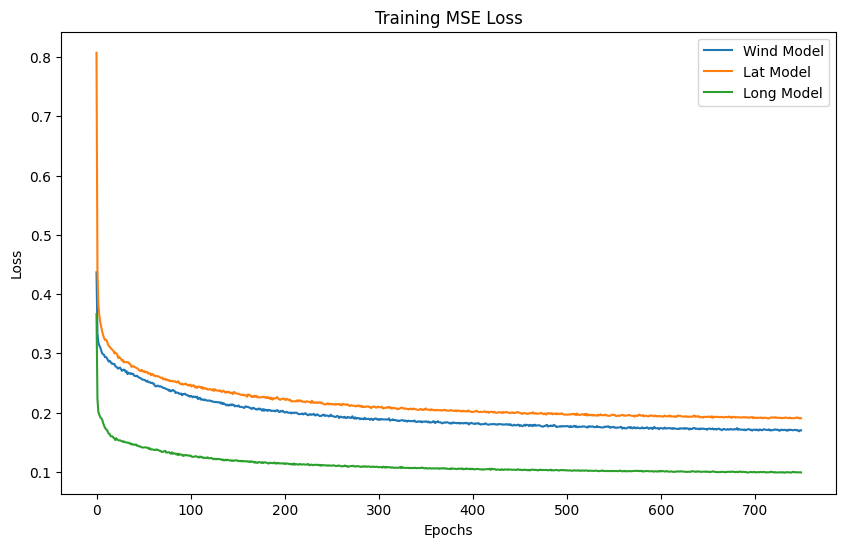

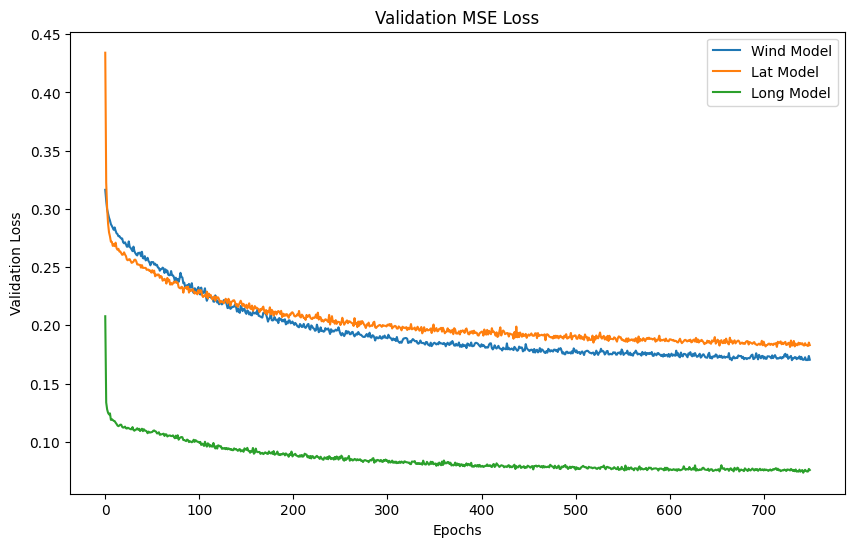

In [43]:
# Plot loss over time
plt.figure(figsize=(10, 6))
plt.plot(wind_loss, label="Wind Model")
plt.plot(lat_loss, label="Lat Model")
plt.plot(long_loss, label="Long Model")
plt.title("Training MSE Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot validation loss over time
plt.figure(figsize=(10, 6))
plt.plot(wind_val_loss, label="Wind Model")
plt.plot(lat_val_loss, label="Lat Model")
plt.plot(long_val_loss, label="Long Model")
plt.title("Validation MSE Loss")
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.legend()
plt.show()

# Model Evaluation


In [44]:
test_data = [] # data cleaning/processing: (from hurricane-net, hammad)
db = []
with open('data/hurdat2-1851-2022-050423.txt') as raw: 
    for line in raw: 
        line = line.replace(' ', '').split(',')
    
        # Identify atlantic storm, first 2 letters should be AL
        if (line[0][:2] == 'AL') :
            storm_id = line[0]
            storm_name = line[1]
            storm_entries = line[2]

            # Iterate and read through best track entries
            for i in range(int(storm_entries)) :
                entry = raw.readline().replace(' ', '').split(',')
                # Filter -999 placeholder for missing central pressure
                entry = [None if x == "-999" else x for x in entry]
                # Construct date and time based on first two columns
                timestamp = datetime.datetime(int(entry[0][:4]), int(entry[0][4:6]), int(entry[0][6:8]), int(entry[1][:2]), int(entry[1][3:]))
                # Add entry into our current database
                db.append([storm_id, storm_name, timestamp] + entry[2:-1])
        else :
            print("Error, unidentified storm ".join(str(line[0])))

# Return DataFrame
test_data = pd.DataFrame(db, columns = ['storm_id', 'storm_name', 'entry_time', 'entry_id', 'entry_status', 'lat', 'long','max_wind', 'min_pressure', '34kt_ne', '34kt_se', '34kt_sw', '34kt_nw', '50kt_ne', '50kt_se', '50kt_sw', '50kt_nw', '64kt_ne', '64kt_se', '64kt_sw', '64kt_nw'])

In [45]:
desired_years = [1969, 1986, 2005]

# Parse in hurricanes
hurricanes_target = dict()
print("Transforming 2005, 1986, 1969 HURDAT2 into objects . . .")
for index, entry in test_data.iterrows() :
    print("Transforming {}/{} entries from HURDAT2".format(index + 1, len(dataset)), end = "\r")
    # Filter to capture 2017 data
    if int(entry['storm_id'][-4:]) not in desired_years:
        continue
    if entry['storm_id'] not in hurricanes_target:
        hurricanes_target[entry['storm_id']] = hurricane(entry['storm_name'], entry['storm_id'])
        storm_ids[entry['storm_id']] = entry['storm_name']
    # Add entry to hurricane
    hurricanes_target[entry['storm_id']].add_entry(entry[2:])
print("\nDone!")

Transforming 2005, 1986, 1969 HURDAT2 into objects . . .
Transforming 53976/53976 entries from HURDAT2
Done!


In [46]:
# Filter storms that have more than 6 entries. We need at least 6 to calculate 5 speed vectors
storms_filter = [storm for storm in hurricanes_target.values() if len(storm.entries) > 6]

# Begin creating hurricane forecast and track predictions
tracks = {
    'storms' : [], # Reference storm
    'inputs' : [], # The inputs for the ai
    'valid_times' : [], # The valid time to compare to the error database
}
for index, storm in enumerate(storms_filter) :
    # Create inputs to ai. ai requires scaled data as input
    entries = [entry[1] for entry in sorted(storm.entries.items())] # Extracts data from data structure
    
    # Scale the entries
    for start_index in range(1, len(entries) - 5) : # Go through each entry
        # Build feature extraction
        extracted_features = []
        valid_time = None # Going to be set to the last element in the series
        for pivot in range(start_index, start_index + 5) :
            extracted_features.append(np.array(list(feature_extraction(entries[pivot], entries[pivot - 1]).values())))
            if pivot is start_index + 4 : # We're on the last element
                valid_time = entries[pivot]['entry_time']
        
        # If there's an incomplete value we can't process, skip it
        if any(None in entry for entry in extracted_features) :
            continue
            
        # Scale extracted features        
        scaled_entries = scaler.transform(extracted_features)
        
        # Add to our results
        tracks['storms'].append(storm)
        tracks['inputs'].append(scaled_entries.tolist())
        tracks['valid_times'].append(valid_time)
        
    print("\rDone with track processing {}/{} storms".format(index + 1, len(storms_filter)), end = '')
tracks['inputs'] = np.array(tracks['inputs'])

Done with track processing 61/61 storms

In [47]:
# Define a function to return the distance between two coordinates in nautical miles
import math

def distance(origin, destination):
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371 # km

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c

    return d * 0.539957 # km to nautical miles

In [48]:
tracks['wind_predictions_raw'] = wind_model.predict(tracks['inputs'])
tracks['lat_predictions_raw'] = lat_model.predict(tracks['inputs'])
tracks['long_predictions_raw'] = long_model.predict(tracks['inputs'])

 1/45 [..............................] - ETA: 2s

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


45/45 [==============================] - 2s 47ms/step


In [49]:
# Scale back and store our wind predictions and our lat, long predictions
tracks['wind_predictions'] = []
tracks['lat_predictions'] = []
tracks['long_predictions'] = []
intensity_errors = {
    '24' : [],
    '48' : [],
    '72' : [],
    '96' : [],
    '120' : []
}
track_errors = {
    '24' : [],
    '48' : [],
    '72' : [],
    '96' : [],
    '120' : []
}
for index, prediction in enumerate(tracks['wind_predictions_raw']) :
    # Use our standard scaler to scale the raw predictions back
    winds_scaled = [scaler.inverse_transform([[0,0,winds[0],0,0,0,0,0,0,0,0,0,0,0] for winds in prediction])] # Index 2 is winds
    lat_scaled = [scaler.inverse_transform([[lats[0],0,0,0,0,0,0,0,0,0,0,0,0,0] for lats in tracks['lat_predictions_raw'][index]])] # Index 0 is lat
    long_scaled = [scaler.inverse_transform([[0,longs[0],0,0,0,0,0,0,0,0,0,0,0,0] for longs in tracks['long_predictions_raw'][index]])] # Index 1 is long
    
    # Extract the wind prediction from data structure and store into new data structure
    for i in range(len(winds_scaled)) :        
        # The new data structure is a tuple of (wind, storm_id, valid_time, forecast_time)
        wind_predictions = []
        lat_predictions = []
        long_predictions = []
        for step, pred in enumerate(winds_scaled[i]) :
            wind = pred[2]
            lat = lat_scaled[i][step][0]
            long = long_scaled[i][step][1]
            
            storm_id = tracks['storms'][index].id
            valid_time = tracks['valid_times'][index]
            forecast_time = valid_time + datetime.timedelta(days = step + 1)
            
            # See if we can find the error
            if forecast_time in hurricanes_target[storm_id].entries :
                wind_truth = hurricanes_target[storm_id].entries[forecast_time]['max_wind']
                lat_truth = hurricanes_target[storm_id].entries[forecast_time]['lat']
                long_truth = hurricanes_target[storm_id].entries[forecast_time]['long']
                intensity_error = abs(wind_truth - wind)
                track_error = distance((lat_truth,long_truth), (lat, long))
                
                wind_predictions.append({
                    'ai-wind' : wind,
                    'truth' : wind_truth,
                    'storm_id' : storm_id,
                    'valid_time' : valid_time,
                    'forecast_time' : forecast_time
                })
                lat_predictions.append({
                    'ai-lat' : lat,
                    'truth' : lat_truth,
                    'storm_id' : storm_id,
                    'valid_time' : valid_time,
                    'forecast_time' : forecast_time
                })
                long_predictions.append({
                    'ai-long' : long,
                    'truth' : long_truth,
                    'storm_id' : storm_id,
                    'valid_time' : valid_time,
                    'forecast_time' : forecast_time
                })
                if step == 0 :
                    intensity_errors['24'].append(intensity_error)
                    track_errors['24'].append(track_error)
                if step == 1 :
                    intensity_errors['48'].append(intensity_error)
                    track_errors['48'].append(track_error)
                if step == 2 :
                    intensity_errors['72'].append(intensity_error)
                    track_errors['72'].append(track_error)
                if step == 3 :
                    intensity_errors['96'].append(intensity_error)
                    track_errors['96'].append(track_error)
                if step == 4 :
                    intensity_errors['120'].append(intensity_error)
                    track_errors['120'].append(track_error)
                    
        tracks['wind_predictions'].append(wind_predictions)
        tracks['lat_predictions'].append(lat_predictions)
        tracks['long_predictions'].append(long_predictions)

In [50]:
# Compare predictions when we can find them
katrina_pred = {
    'latitude': [],
    'longitude': []
}
katrina_real = {
    'latitude': [],
    'longitude': []
}
andrew_pred = {
    'latitude': [],
    'longitude': []
}
andrew_real = {
    'latitude': [],
    'longitude': []
}
camille_pred = {
    'latitude': [],
    'longitude': []
}
camille_real = {
    'latitude': [],
    'longitude': []
}

ai_wind_errors = []
ai_track_errors = []
for index, prediction in enumerate(tracks['wind_predictions']) :
    # Find the time stamp for the storm ID in the error database
    if prediction == [] :
      continue
    valid_time = prediction[0]['valid_time']
    storm_id = prediction[0]['storm_id']
    if(storm_id != 'AL011986' and storm_id != 'AL122005' and storm_id != 'AL091969'):
      continue
    print(valid_time)
    # If we find it, compare
    for i, forecast in enumerate(prediction) :
        print("\tIntensity Truth: {}, AI forecast: {}".format(forecast['truth'], forecast['ai-wind']))
        print("\tTrajectory Truth: {}, {}; AI forecast: {}, {} ; AI error: {}".format(tracks['lat_predictions'][index][i]['truth'],
                                                                                                tracks['long_predictions'][index][i]['truth'],
                                                                                                tracks['lat_predictions'][index][i]['ai-lat'],
                                                                                                tracks['long_predictions'][index][i]['ai-long'],
                                                                                                distance((tracks['lat_predictions'][index][i]['truth'], tracks['long_predictions'][index][i]['truth']), (tracks['lat_predictions'][index][i]['ai-lat'], tracks['long_predictions'][index][i]['ai-long'])),))
        print()
        if storm_id == 'AL122005':
          katrina_pred['latitude'].append(tracks['lat_predictions'][index][i]['ai-lat'])
          katrina_pred['longitude'].append(tracks['long_predictions'][index][i]['ai-long'])
          katrina_real['latitude'].append(tracks['lat_predictions'][index][i]['truth'])
          katrina_real['longitude'].append(tracks['long_predictions'][index][i]['truth'])
        if storm_id == 'AL091969':
          camille_pred['latitude'].append(tracks['lat_predictions'][index][i]['ai-lat'])
          camille_pred['longitude'].append(tracks['long_predictions'][index][i]['ai-long'])
          camille_real['latitude'].append(tracks['lat_predictions'][index][i]['truth'])
          camille_real['longitude'].append(tracks['long_predictions'][index][i]['truth'])
        if storm_id == 'AL011986':
          andrew_pred['latitude'].append(tracks['lat_predictions'][index][i]['ai-lat'])
          andrew_pred['longitude'].append(tracks['long_predictions'][index][i]['ai-long'])
          andrew_real['latitude'].append(tracks['lat_predictions'][index][i]['truth'])
          andrew_real['longitude'].append(tracks['long_predictions'][index][i]['truth'])
        ai_wind_errors.append(abs(forecast['truth'] - forecast['ai-wind']))
        ai_track_errors.append(abs(distance((tracks['lat_predictions'][index][i]['truth'], tracks['long_predictions'][index][i]['truth']), (tracks['lat_predictions'][index][i]['ai-lat'], tracks['long_predictions'][index][i]['ai-long']))))

1969-08-15 06:00:00
	Intensity Truth: 105.0, AI forecast: 74.76395845413208
	Trajectory Truth: 23.1, 85.2; AI forecast: 26.526599216461182, 81.45622220635414 ; AI error: 289.70790309715846

1969-08-15 12:00:00
	Intensity Truth: 130.0, AI forecast: 67.01071619987488
	Trajectory Truth: 23.8, 86.0; AI forecast: 29.250636196136476, 80.62527862787246 ; AI error: 436.2827188983328

1969-08-15 18:00:00
	Intensity Truth: 150.0, AI forecast: 67.7514910697937
	Trajectory Truth: 24.3, 86.6; AI forecast: 32.10181159973145, 83.23253961801528 ; AI error: 501.0763564726541

1969-08-16 00:00:00
	Intensity Truth: 150.0, AI forecast: 73.77575397491455
	Trajectory Truth: 25.2, 87.2; AI forecast: 32.52631530761719, 83.62800488471984 ; AI error: 478.19777228765

1969-08-16 06:00:00
	Intensity Truth: 145.0, AI forecast: 72.7599549293518
	Trajectory Truth: 26.0, 87.7; AI forecast: 34.53885669708252, 78.7213270485401 ; AI error: 691.8701130452064

1969-08-16 12:00:00
	Intensity Truth: 140.0, AI forecast: 73.1

In [51]:
# Plotting hurricane katrina
import cartopy
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

def plot_trajectory(real_latitudes, real_longitudes, predicted_latitudes, predicted_longitudes): 
  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

  # Plot the real trajectory
  ax.plot(real_longitudes, real_latitudes, marker='o', transform=ccrs.Geodetic(), color='blue', label='Real')

  # Plot the predicted trajectory
  ax.plot(predicted_longitudes, predicted_latitudes, marker='o', transform=ccrs.Geodetic(), color='red', label='Predicted')

  ax.set_extent([min(real_longitudes + predicted_longitudes) - 1, max(real_longitudes + predicted_longitudes) + 1,
                min(real_latitudes + predicted_latitudes) - 1, max(real_latitudes + predicted_latitudes) + 1],
                crs=ccrs.PlateCarree())
  ax.set_title('Trajectory Comparison')
  ax.legend()

  ax.coastlines(resolution='10m')
  ax.gridlines(draw_labels=True, linestyle='--')
  # Uncomment the line below if you want to add a background image
  # ax.stock_img()

  plt.show()

In [ ]:
plot_trajectory(katrina_real['latitude'], katrina_real['longitude'], katrina_pred['latitude'], katrina_pred['longitude'])

In [ ]:
pd.DataFrame(ai_wind_errors).describe()

In [ ]:
pd.DataFrame(ai_track_errors).describe()